In [1]:
import torch
from torchvision.datasets import CIFAR10
from torch.utils.data import Dataset
import torchvision.transforms as tvt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import random
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [2]:
class AddGaussianNoise(object):
    def __init__(self, mean=0.0, std=1.0):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + "(mean={0}, std={1})".format(
            self.mean, self.std
        )

In [3]:
# class which overrides the getitem function of the original CIFAR 10 dataset to create a pair of noisy image and clean image
class ImageDataset(CIFAR10):
    def __init__(
        self,
        root,
        train=True,
        transform=None,
        target_transform=None,
        download=False,
        sigma=1.0,
    ):
        super(ImageDataset, self).__init__(
            root, train, transform, target_transform, download
        )
        self.transform_noise = tvt.Compose(
            [
                tvt.ToTensor(),
                AddGaussianNoise(0.0, sigma / 255),
            ]
        )
        self.transform_clean = tvt.Compose(
            [
                tvt.ToTensor(),
            ]
        )

    def __getitem__(self, idx):
        features, target = super(ImageDataset, self).__getitem__(idx)
        noisy_image = torch.clamp(self.transform_noise(features),0,1)
        clean_image = self.transform_clean(features)
        return noisy_image, clean_image

In [4]:
# dCNN model class used by the paper
class dCNN(torch.nn.Module):
    def __init__(self, channels, layers=15):
        super(dCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(
            in_channels=channels, out_channels=16, kernel_size=3, padding=1, bias=False
        )
        self.convList = torch.nn.ModuleList()
        for i in range(layers - 2):
            self.convList.append(
                torch.nn.Conv2d(
                    in_channels=16,
                    out_channels=16,
                    kernel_size=3,
                    padding=1,
                    bias=False,
                )
            )
            self.convList.append(torch.nn.BatchNorm2d(16))
            self.convList.append(torch.nn.ReLU(inplace=True))
        self.conv2 = torch.nn.Conv2d(
            in_channels=16, out_channels=channels, kernel_size=3, padding=1, bias=False
        )

    def forward(self, x):
        x = self.conv1(x)
        x = torch.nn.functional.relu(x, inplace=True)
        for conv in self.convList:
            x = conv(x)
        x = self.conv2(x)
        return x

In [5]:
# function to check PSNR(dB)/SSIM values of the resulted images
def calculate_metrics(image, original):
    image = image.data.cpu().numpy().astype(np.float32)
    original = original.data.cpu().numpy().astype(np.float32)
    psnr_value = 0
    ssim_value = 0
    for i in range(image.shape[0]):
        psnr_value += psnr(
            original[i, :, :, :], image[i, :, :, :],
        )
        ssim_value += ssim(
            original[i, :, :, :],
            image[i, :, :, :],
            channel_axis=0,
        )
    psnr_value /= image.shape[0]
    ssim_value /= image.shape[0]

    return psnr_value, ssim_value

In [6]:
# training function
def train(model, dataloader, device, epochs):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=4e-3)
    criterion = torch.nn.MSELoss()
    alpha = 10
    for epoch in range(epochs):
        running_loss = 0.0
        psnr_value = 0.0
        ssim_value = 0.0
        for idx, data in enumerate(dataloader):
            model.train()
            optimizer.zero_grad()
            noisy_image, clean_image = data
            noisy_image = noisy_image.to(device)
            clean_image = clean_image.to(device)
            sigma = np.random.uniform(0/255, 50/255)
            D = (sigma * torch.FloatTensor(noisy_image.size()).normal_(mean=0)).cuda()
            input = torch.clamp(noisy_image + alpha * D,0,1)
            target = torch.clamp(noisy_image - D / alpha,0,1)
            output = torch.clamp(model(input),0,1)
            loss = criterion(output, target)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()

            # evaluating the performance per batch
            model.eval()
            output = torch.clamp(model(noisy_image), 0, 1)
            psnr_val, ssim_value = calculate_metrics(output, clean_image)
            psnr_value += psnr_val
            ssim_value += ssim_value
            if idx != 0 and (idx+1) % 100 == 0:
                print(
                    "Epoch:",
                    epoch + 1,
                    "[",
                    idx + 1,
                    "/",
                    len(dataloader),
                    "]",
                    "=>",
                    "PSNR:",
                    psnr_value / 100,
                    "Loss:",
                    running_loss / 100,
                    "SSIM:",
                    ssim_value / 100,
                )
                running_loss = 0.0
                psnr_value = 0.0
                ssim_value = 0.0
    file_name = "model_" + str(sigma) + ".pth"
    torch.save(model.state_dict(), file_name)

In [7]:
# testing function
def test(dataset, model, model_path, sigma, device):
    model.load_state_dict(torch.load(model_path))
    model.eval()
    psnr_list = []
    ssim_list = []
    test_output = None
    for i in range(len(dataset)):
        noisy_image, clean_image = dataset[i]
        input = torch.unsqueeze(noisy_image, 0).to(device)
        clean_image = torch.unsqueeze(clean_image, 0).to(device)
        with torch.no_grad():
            output = model(input)
        out = torch.clamp(output, 0, 1)
        psnr_val, ssim_value = calculate_metrics(out, clean_image)
        psnr_list.append(psnr_val)
        ssim_list.append(ssim_value)
    print(
        "PSNR of testing dataset:",
        sum(psnr_list) / len(psnr_list),
        "SSIM of testing dataset:",
        sum(ssim_list) / len(ssim_list),
    )

In [57]:
# function to take one pair of clean and noisy pair of images randomly and compare those against the resultant denoised image
def sample_testing(dataset, model, model_path, sigma, device):

    model.load_state_dict(torch.load(model_path))

    model.eval()

    idx = random.randint(0, 1000)

    noisy_image, clean_image = dataset[idx]

    test_output = None
    # adding dimension to noisy and clean image

    input = torch.unsqueeze(noisy_image, 0).to(device)

    clean_image = torch.unsqueeze(clean_image, 0).to(device)

    with torch.no_grad():
        output = model(input)

    out = torch.clamp(output, 0, 1)

    psnr_val, ssim_value = calculate_metrics(out, clean_image)

    fig, axes = plt.subplots(1, 3)
    # inverting the normalization to get the original image by multiplying std and adding mean

    noisy_image = tvt.ToPILImage()(torch.squeeze(noisy_image))

    axes[1].imshow(noisy_image)

    axes[1].set_title("Noisy Image")

    clean_image = tvt.ToPILImage()(torch.squeeze(clean_image))

    axes[0].imshow(clean_image)

    axes[0].set_title("Clean Image")

    out_image = tvt.ToPILImage()(torch.squeeze(out))

    axes[2].imshow(out_image)

    axes[2].set_title("Denoised Image")


    fig.suptitle(
        "PSNR: "
        + str(round(psnr_val, 2))
        + " SSIM: "
        + str(round(ssim_value, 2))
        + " when σ="
        + str(sigma)
    )

    plt.show()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


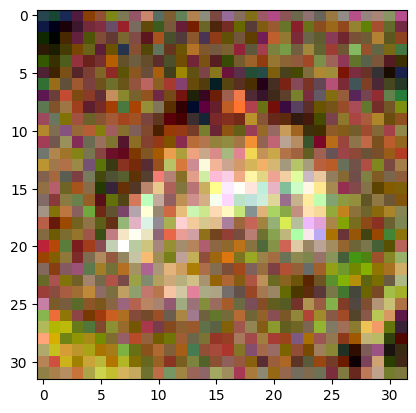

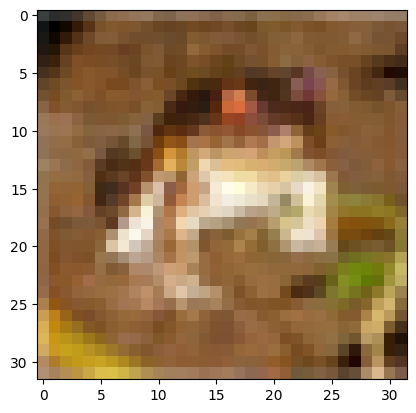

In [74]:
# main pipeline

# setting up the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# training dataset
training_dataset_25 = ImageDataset("./training", train=True, download=True, sigma=25)
training_dataset_50 = ImageDataset("./training", train=True, download=True, sigma=50)
# testing dataset
testing_dataset_25 = ImageDataset("./testing", train=False, download=True, sigma=25)
testing_dataset_50 = ImageDataset("./testing", train=False, download=True, sigma=50)
# training dataloader
train_DL_25 = torch.utils.data.DataLoader(
    training_dataset_25, batch_size=100, shuffle=True, num_workers=10
)
train_DL_50 = torch.utils.data.DataLoader(
    training_dataset_50, batch_size=100, shuffle=True, num_workers=10
)
# testing dataloader (not needed)
test_DL_25 = torch.utils.data.DataLoader(
    testing_dataset_25, batch_size=100, shuffle=True, num_workers=2
)
test_DL_50 = torch.utils.data.DataLoader(
    testing_dataset_50, batch_size=100, shuffle=True, num_workers=2
)
# initialze the model
model = dCNN(channels=3)

n_img, c_img = training_dataset_25[0]
plt.imshow(tvt.ToPILImage()(n_img))
plt.show()
plt.imshow(tvt.ToPILImage()(c_img))
plt.show()

In [10]:
# training the model with sigma = 25
train(model, train_DL_25, device, 100)  # trained model saved in model_25.pth

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 [ 100 / 500 ] => PSNR: 11.393549868249815 Loss: 0.042510494086891414 SSIM: 0.009158878685534
Epoch: 1 [ 200 / 500 ] => PSNR: 14.281738992701127 Loss: 0.03449213091284037 SSIM: 0.012705766808986664
Epoch: 1 [ 300 / 500 ] => PSNR: 13.96035270356458 Loss: 0.033646260257810354 SSIM: 0.01067969900816679
Epoch: 1 [ 400 / 500 ] => PSNR: 15.002616546629374 Loss: 0.03187745314091444 SSIM: 0.010488826513290406
Epoch: 1 [ 500 / 500 ] => PSNR: 15.29867041734878 Loss: 0.031868408992886545 SSIM: 0.011521434339880943
Epoch: 2 [ 100 / 500 ] => PSNR: 15.083290980952924 Loss: 0.031355093456804754 SSIM: 0.011565468108654022
Epoch: 2 [ 200 / 500 ] => PSNR: 14.88555433914541 Loss: 0.031334468238055704 SSIM: 0.012776431626081466
Epoch: 2 [ 300 / 500 ] => PSNR: 14.982778757011568 Loss: 0.031748551353812215 SSIM: 0.012224008214473725
Epoch: 2 [ 400 / 500 ] => PSNR: 16.213981915600176 Loss: 0.028639235254377126 SSIM: 0.01457960737347603
Epoch: 2 [ 500 / 500 ] => PSNR: 15.954230534924275 Loss: 0.029322

In [12]:
# testing the mode with sigma = 25
test(testing_dataset_25, model, "./model_25.pth", 25, device)

PSNR of testing dataset: 18.51764724607121 SSIM of testing dataset: 0.6693963537611067


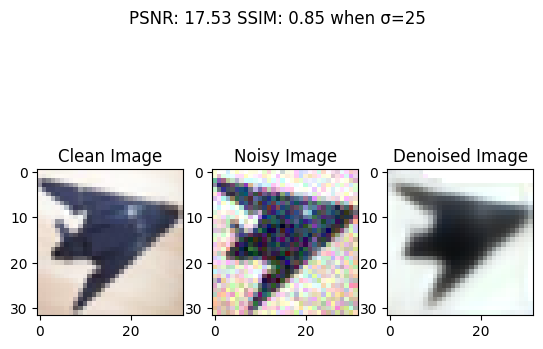

In [134]:
sample_testing(testing_dataset_25, model, "./model_25.pth", 25, device)

In [133]:
train(model, train_DL_50, device, 100)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


KeyboardInterrupt: 

In [77]:
test(testing_dataset_25, model, "./model_50.pth", 50, device)

PSNR of testing dataset: 20.15480637570781 SSIM of testing dataset: 0.705350793877244


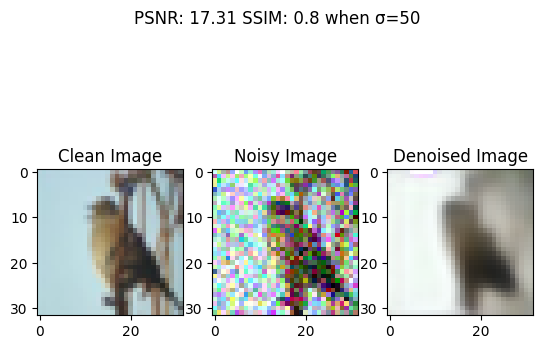

In [142]:
sample_testing(testing_dataset_50, model, "./model_25.pth", 50, device)